In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
SB_normais = pd.read_csv('../gerais/SB_geral.csv').query("normal_ecg == True")[['exam_id', 'tipo', 'silhouette_score']]
ST_normais = pd.read_csv('../gerais/ST_geral.csv').query("normal_ecg == True")[['exam_id', 'tipo', 'silhouette_score']]
AF_normais = pd.read_csv('../gerais/AF_geral.csv').query("normal_ecg == True")[['exam_id', 'tipo', 'silhouette_score']]
RBBB_normais = pd.read_csv('../gerais/RBBB_geral.csv').query("normal_ecg == True")[['exam_id', 'tipo', 'silhouette_score']]
LBBB_normais = pd.read_csv('../gerais/LBBB_geral.csv').query("normal_ecg == True")[['exam_id', 'tipo', 'silhouette_score']]

merged_df = SB_normais.merge(ST_normais, on='exam_id', suffixes=('_SB', '_ST'), how='inner')
merged_df = merged_df.rename(columns={'tipo': 'tipo_SB'})
merged_df = merged_df.merge(AF_normais, on='exam_id', how='inner')
merged_df = merged_df.rename(columns={'tipo': 'tipo_AF', 'silhouette_score': 'silhouette_AF'})
merged_df = merged_df.merge(RBBB_normais, on='exam_id', suffixes=('', '_RBBB'), how='inner')
merged_df = merged_df.rename(columns={'tipo': 'tipo_RBBB', 'silhouette_score': 'silhouette_RBBB'})
merged_df = merged_df.merge(LBBB_normais, on='exam_id', suffixes=('', '_LBBB'), how='inner')
merged_df = merged_df.rename(columns={'tipo': 'tipo_LBBB', 'silhouette_score': 'silhouette_LBBB'})

merged_df.to_csv('_consenso_normais.csv', index=False)

In [35]:
target_values = ['N_clusterN']

for target_value in target_values:
    rows_with_target = merged_df[
        (merged_df['tipo_SB'] == target_value) | (merged_df['tipo_ST'] == target_value) |
        (merged_df['tipo_AF'] == target_value) | (merged_df['tipo_RBBB'] == target_value) |
        (merged_df['tipo_LBBB'] == target_value)
    ]

    rows_with_consensus = rows_with_target[
        (rows_with_target['tipo_SB'] == target_value) & (rows_with_target['tipo_ST'] == target_value) &
        (rows_with_target['tipo_AF'] == target_value) & (rows_with_target['tipo_RBBB'] == target_value) &
        (rows_with_target['tipo_LBBB'] == target_value)
    ]

    percentage_consensus = 0.0
    if len(rows_with_target) > 0:
        percentage_consensus = len(rows_with_consensus) / len(rows_with_target) * 100

    print(f"Number of rows with '{target_value}': {len(rows_with_target)}")
    print(f"Number of rows with consensus: {len(rows_with_consensus)}")
    print(f"Percentage of rows with '{target_value}' that have consensus: {percentage_consensus:.2f}%")
    print()

Number of rows with 'N_clusterN': 20000
Number of rows with consensus: 18206
Percentage of rows with 'N_clusterN' that have consensus: 91.03%



                        Proportion
tipo_SB vs tipo_AF         0.97920
tipo_AF vs tipo_LBBB       0.97245
tipo_ST vs tipo_AF         0.96090
tipo_SB vs tipo_LBBB       0.95875
tipo_ST vs tipo_LBBB       0.95870
tipo_RBBB vs tipo_LBBB     0.95845
tipo_AF vs tipo_RBBB       0.95040
tipo_SB vs tipo_ST         0.94700
tipo_SB vs tipo_RBBB       0.93680
tipo_ST vs tipo_RBBB       0.93320


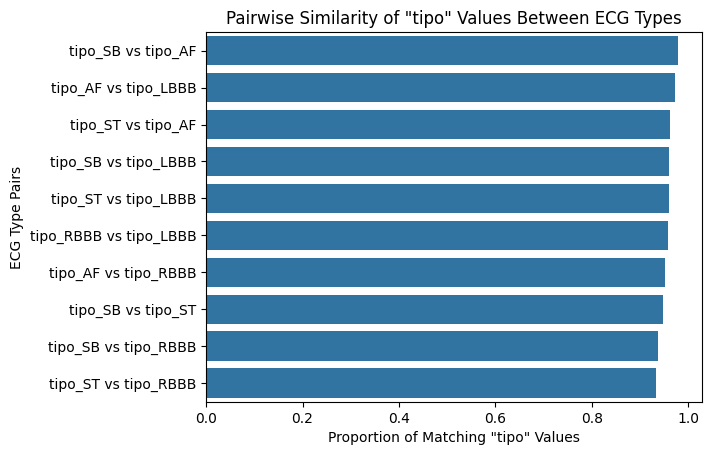

In [4]:
# Create pairwise comparisons between 'tipo' columns
pairs = [(a, b) for idx, a in enumerate(merged_df.filter(like='tipo').columns) 
                 for b in merged_df.filter(like='tipo').columns[idx + 1:]]

# Calculate the proportion of matching 'tipo' values for each pair
pairwise_similarity = {}
for a, b in pairs:
    pairwise_similarity[f'{a} vs {b}'] = (merged_df[a] == merged_df[b]).mean()

# Convert to DataFrame for easier analysis
pairwise_similarity_df = pd.DataFrame.from_dict(pairwise_similarity, orient='index', columns=['Proportion'])
pairwise_similarity_df.sort_values(by='Proportion', ascending=False, inplace=True)

print(pairwise_similarity_df)

# Plot the pairwise similarity
sns.barplot(x=pairwise_similarity_df['Proportion'], y=pairwise_similarity_df.index)
plt.title('Pairwise Similarity of "tipo" Values Between ECG Types')
plt.xlabel('Proportion of Matching "tipo" Values')
plt.ylabel('ECG Type Pairs')
plt.show()

In [44]:
rows_with_consensus['silhouette_mean'] = (
    (rows_with_consensus['silhouette_score_SB'] + 
    rows_with_consensus['silhouette_score_ST'] + 
    rows_with_consensus['silhouette_AF'] + 
    rows_with_consensus['silhouette_RBBB'] + 
    rows_with_consensus['silhouette_LBBB']) / 5
)

merged_df_sorted = rows_with_consensus.sort_values(by='silhouette_mean', ascending=False)

merged_df_sorted = merged_df_sorted.rename(columns={'tipo_SB': 'tipo', 'silhouette_mean': 'silhouette_score'})

top_125_ecgs = merged_df_sorted.head(80)[['exam_id', 'silhouette_score', 'tipo']]

top_125_ecgs['1dAVb'] = False
top_125_ecgs['RBBB'] = False
top_125_ecgs['LBBB'] = False
top_125_ecgs['SB'] = False
top_125_ecgs['ST'] = False
top_125_ecgs['AF'] = False

top_125_ecgs['label'] = 1
top_125_ecgs['normal_ecg'] = True 

top_125_ecgs = top_125_ecgs[['exam_id', 'label', '1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF', 'normal_ecg', 'silhouette_score', 'tipo']]
top_125_ecgs.to_csv('normais_amostras.csv', index=False)

C:\Users\luisa\AppData\Local\Temp\ipykernel_32192\3272508563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows_with_consensus['silhouette_mean'] = (
